<a href="https://colab.research.google.com/github/dibullap/BananaReader_ag/blob/main/DATA101_IndividualProject_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Cooperation between child civilians and guerrilla**
  *Pamela van den Enden*


The central aim of this project was to study the rational prospect for cooperation in post-conflict situations; cooperation, that is, between select groups affected by a conflict, whether as perpetrators or victims. I wanted to explore this theme in the specific post-conflictual context of Colombia. 

Question

Will young civilians cooperate with former insurgent youth?

Hypothesis

In the aftermath of an extended period of conflict between insurgents and state forces, we would not expect civilian children affected by the insurgency to cooperate with insurgent youth under political (and economic) conditions that operate according to game-theoretic frameworks. 


##Librerías 
Se importan las librerías necesarias para el desarrollo del análisis 

In [111]:
#Libraries
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d


#For Chi2
import scipy.stats as stats


import matplotlib.ticker as ticker
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

from sklearn import metrics
from sklearn.metrics import roc_curve
%matplotlib inline


##Carga de datos
Los datos capturados en un archivo excel se cargan dentro de un `dataframe` de `pandas y se muestran las primeras diez entradas de la tabla.`

In [112]:
#Import Data
df = pd.read_excel('Push_Pull_OnlyCompleteGames.xlsx')
print(df['Op_Gender_F_!_M_0'].unique())

[0 1]


Data Pre-Processing

Ahora se debe verificar si hay algún valor ```NaN``` en el ```dataframe``` y si es el caso, eliminar dichos registros

In [113]:
df.isnull().values.any()


False

In [114]:
df.isnull().any()



Id_Pa                      False
Game                       False
Round                      False
Pa_Action_Push_1_Pull_0    False
Op_Action_Push_1_Pull_0    False
Op_Time                    False
Group_Op_Civ_1_guer_0      False
Pa_Gender_F_1_M_0          False
Pa_Age                     False
Pa_School                  False
Op_Name_Naugh_0_Nice_1     False
Op_Gender_F_!_M_0          False
Op_Age                     False
Date_Game                  False
Date_Round                 False
dtype: bool

No hay ningún registro ```NaN``` 

Se estandarizan los tipos de datos de cada columna para una mejor operabilidad, practicidad y eficiencia.


In [115]:
#Change Data Types 
df = df.astype({"Id_Pa": str, "Game": int, 
                "Round": int, 
                "Pa_Action_Push_1_Pull_0":int, 
                "Op_Action_Push_1_Pull_0":int, 
                "Group_Op_Civ_1_guer_0":int, 
                "Op_Age":int, 
                "Pa_Gender_F_1_M_0":int, 
                "Pa_School":str, 
                "Op_Name_Naugh_0_Nice_1":int, 
                "Op_Gender_F_!_M_0":int, 
                "Date_Game":str, 
                "Date_Round":str})


Se debe asegurar que se contengan únicamente datos de juegos complétamente realizados, por lo que serán eliminados los registros asociados a partidas inconculusas

In [116]:
df = df.sort_values(['Id_Pa', 'Game', 'Round'])

Es lógico afirmar que si cada participante jugó 4 juegos de 25 rondas cada uno, su id debe aparecer exactamente 100 veces, de modo que serán eliminados los usuarios que no cuenten con esta característica pues o bien no completaron todos los juegos, o no jugaron todas las rondas.

In [117]:
sv = df['Id_Pa'].value_counts(sort = False)

In [118]:
dr = []
for i in range(sv.shape[0]):
  if sv.iloc[i] != 100:
    dr = dr + [i + 1]
print(dr)

[75]


El usuario número 75 será eliminado de los registros ya que no completó los juegos.

In [119]:
df.drop(df[df['Id_Pa'] == 75].index, inplace = True)


Hay 182 participantes

In [120]:
#Number of Distinct Participants
len(set(df.Id_Pa)) # 180 distinct participants 

182

Data Visualization

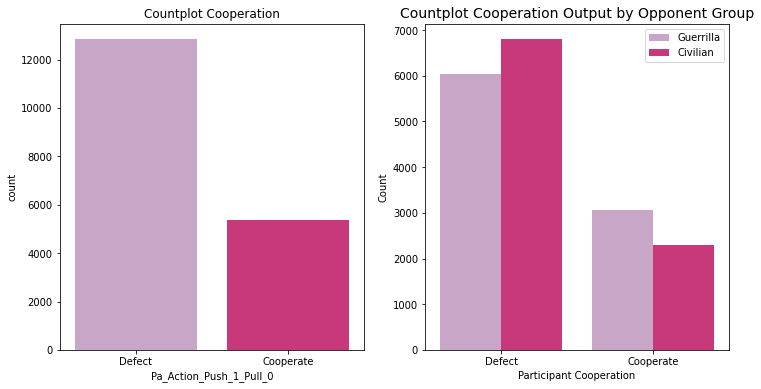

In [121]:
#How balanced is the target variable (Participant's Cooperation)?

g, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(12,6))
ax1.set_title('Countplot Cooperation', fontsize= 12)
ax2.set_title('Countplot Cooperation Output by Opponent Group', fontsize=14)


#Subplot 1 - Overall more cooperation than defection 
sns.countplot(ax=ax1, x='Pa_Action_Push_1_Pull_0', data = df, palette = 'PuRd') 
plt.xlabel('Participant Cooperation', fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.xticks([0, 1], ['Defect', 'Cooperate'], fontsize=10)


#Subplot 2 - 
sns.countplot(ax=ax2, x='Pa_Action_Push_1_Pull_0', hue= 'Group_Op_Civ_1_guer_0',
              data = df, palette = 'PuRd') 
plt.xlabel('Participant Cooperation', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks([0, 1], ['Defect', 'Cooperate'], fontsize=10)
plt.legend(["Guerrilla", "Civilian"])


Dadas las gráficas anteriores es posible observar que:
- Globalmente la mayoría de participantes tiende a *no cooperar*.
- Teniendo en consideración el rol del oponente, hay *más cooperación* hacia los *Exguerrilleros*.

A continuación, se dan valores numéricos exactos de cooperación total y cooperación relacionada al rol del oponente.

In [122]:
#Actual Counts: 

#How cooperative where participants overall?
coop_count = df['Pa_Action_Push_1_Pull_0'].value_counts()
print("Total Defection " + str(coop_count[0]))
print("Total Cooperation " + str(coop_count[1]))

#How cooperative are civilians with Guerrilla? 
crosstab = pd.crosstab(df["Group_Op_Civ_1_guer_0"], df["Pa_Action_Push_1_Pull_0"])
crosstab #Cooperate more with Guerrillas, Defect More with Civilians?


Total Defection 12840
Total Cooperation 5359


Pa_Action_Push_1_Pull_0,0,1
Group_Op_Civ_1_guer_0,,
0,6042,3057
1,6798,2302


Al parecer los niños sienten cierta empatía hacia aquellos que fueron miembros de la guerrilla, por lo que es más probable que tiendan a cooperar con estos, sin embargo, la tendencia está claramente marcada a la no cooperación.

¿Cual es el comportamiento de la cooperación a través del tiempo?

In [123]:
#How does cooperative behavior evolve with time (Number of Rounds)?

df2 = df.copy() #New df to use target variables as Ints
df2 = df2.astype({"Id_Pa": str, "Game": int, "Round": int, "Pa_Action_Push_1_Pull_0":int, "Op_Action_Push_1_Pull_0":int, "Group_Op_Civ_1_guer_0":int, "Op_Age":int, "Pa_Gender_F_1_M_0":str, "Pa_School":str, "Op_Name_Naugh_0_Nice_1":str, "Op_Gender_F_!_M_0":str, "Date_Game":str, "Date_Round":str})
td = {}
for i in range(1,26):
    coop = sum(df2[df2.Round==i].Pa_Action_Push_1_Pull_0)
    td[i] = coop






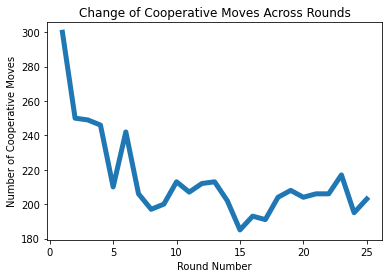

In [124]:

x, y = (list(td.keys()), list(td.values()))
plt.Figure(figsize=(5, 2.7), constrained_layout=True, linewidth=5, edgecolor='black')
plt.plot(x, y, linewidth=5)
plt.xlabel('Round Number')
plt.ylabel('Number of Cooperative Moves')
plt.title("Change of Cooperative Moves Across Rounds")
plt.show()

La cooperación inicia elevada pero tiende a descender de forma oscilante conforme avanza el juego.

Para ver esto más a profundidad, se verá la variación a través de cada ronda de la cooperación en relacion al rol tomado por la máquina.

In [125]:
log_x = np.log(x)
log_y = np.log(y)

c = np.polyfit(log_x, y, 1)
print(c)

[-25.33925035 273.15071495]


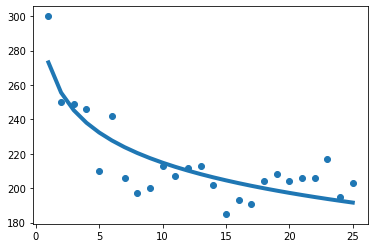

In [126]:
k = c[0] * log_x + c[1]

fig = plt.figure()
ax = fig.subplots()
ax.plot(x, k, linewidth=4, label="Ajuste")
ax.scatter(x, y)


Aunque el ajuste no es perfecto (Considerando que la naturaleza de la cooperación puede depender de más variables fuera del tiempo) se puede aproximar la cantidad total de cooperación a una ronda como:

$$c(r) \approx -25.33\cdot \log (r) + 273.15 $$
Donde $r$ es la ronda actual.

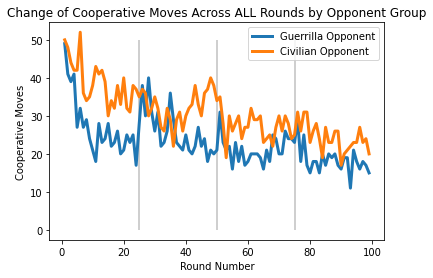

In [127]:
#How does cooperative behavior evolve with time (Across ALL games, ALL rounds)?
#Does cooperative behavior vary with respect to the opponent identity?
'''
def f(row):
    if row.Game==1: return row.Round
    if row.Game==2: return row.Round + 25
    if row.Game==3: return row.Round + 50
    if row.Game==4: return row.Round + 75
  '''
def f(row):
  return row.Round + 25 * (row.Game - 1)

df2['Cumulative_Round'] = df2.apply(lambda row: f(row), axis=1)


td = {}

for i in range(1,100):
    coop_1 = sum(df2[(df2.Cumulative_Round==i) & (df2.Group_Op_Civ_1_guer_0 == 1)].Pa_Action_Push_1_Pull_0)
    coop_0 = sum(df2[(df2.Cumulative_Round==i) & (df2.Group_Op_Civ_1_guer_0 == 0)].Pa_Action_Push_1_Pull_0)
    td[i] = [coop_1, coop_0]
    

plt.vlines(x = [25, 50, 75], ymin = 0, ymax = 50,
           colors = 'black', alpha=0.25)
    
plt.plot(list(td.keys()), list(td.values()), linewidth=3)
plt.xlabel('Round Number')
plt.ylabel('Cooperative Moves')
plt.legend(["Guerrilla Opponent", "Civilian Opponent"])
plt.title("Change of Cooperative Moves Across ALL Rounds by Opponent Group")
plt.show()

En ambos casos el juego se desarrolla de forma similar pero con la enunciada cooperación sesgada hacia los exguerrilleross

También se puede observar qué tanto empatan las acciones del participante y su oponente.

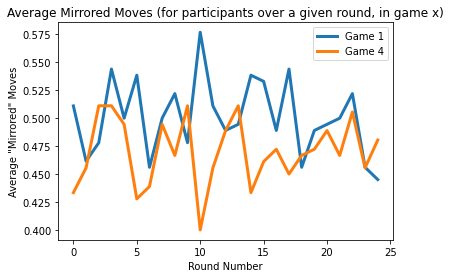

In [128]:
#How matched are participant's and opponent's actions?

df2['mirror'] = df2.Pa_Action_Push_1_Pull_0 == df2.Op_Action_Push_1_Pull_0
df2['mirror'] = df2.mirror.astype(int)

plt.plot(list(df2[df2.Game==1].groupby(['Game', 'Round']).mean().mirror), linewidth=3, label='1')
# plt.plot(list(df2[df2.Game==2].groupby(['Game', 'Round']).mean().mirror), label='2')
# plt.plot(list(df2[df2.Game==3].groupby(['Game', 'Round']).mean().mirror), label='3')
plt.plot(list(df2[df2.Game==4].groupby(['Game', 'Round']).mean().mirror),linewidth=3, label='4')
# plt.plot(list(df2[df2.Game==1].groupby(['Game', 'Round']).var().mirror))

plt.xlabel('Round Number')
plt.ylabel('Average "Mirrored" Moves')
plt.title('Average Mirrored Moves (for participants over a given round, in game x)')
plt.legend(["Game 1", "Game 4"])


Entre el primer y cuarto juego, los empates son similares. aunque la primera tiene un pico más elevado. mientras que en el cuarto es un poco más regular.

Se puede visualizar el promedio de movimientos espejo por parte de los participantes en determinado juego (en este caso el primero).

Text(0.5, 1.0, 'Average Mirrored Moves (for participants over a given round, in game 1)')

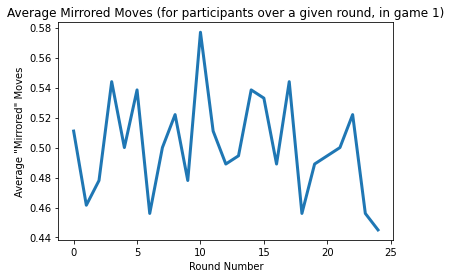

In [129]:
#Action Mirroring Continued *NEED TO FIGURE THIS OUT!

g = 1 #Whats going on in Round10? It is showing either a DIP or BUMP in all games

df2['mirror'] = df2.Pa_Action_Push_1_Pull_0 == df2.Op_Action_Push_1_Pull_0
df2['mirror'] = df2.mirror.astype(int)

# plt.plot(list(df[df.Game==g].groupby(['Game', 'Round']).mean().mirror))
plt.plot(list(df2[df2.Game==g].groupby(['Game', 'Round']).mean().mirror), linewidth = 3)

plt.xlabel('Round Number')
plt.ylabel('Average "Mirrored" Moves')
plt.title('Average Mirrored Moves (for participants over a given round, in game {g})'.format(g=g))

En este juego es bastante regular, aunque en una ronda en particular este suceso es infrecuente.

##Data Analysis
###*Chi-Square Analysis*

¿La cooperación depende de si el oponente es exguerrillero?
Dados los datos recopilados y preprocesados, es posible hacer un análisis de Ji cuadrado para evaluar si la hipótesis es cierta.

In [130]:
#Does cooperation depend on whether or not the opponent is guerrilla? 
crosstab

Pa_Action_Push_1_Pull_0,0,1
Group_Op_Civ_1_guer_0,,
0,6042,3057
1,6798,2302


In [131]:
chi_test = stats.chi2_contingency(crosstab)
chi_test #p-value 9.066326423326767e-35  Variables are dependent on each other

(150.48062602508236,
 1.3611544440704256e-34,
 1,
 array([[6419.64723336, 2679.35276664],
        [6420.35276664, 2679.64723336]]))

Considerando que la estadística $150.48 > 1.36\times 10^{-34}$ es posible afirmar que hay una dependencia entre el rol tomado por el oponente y la decisión del participante.

###*Using ML classifiers*


Se utilizará un modelo de aprendizaje de máquina basado en árboles de decisión para predecir la cooperación de un participante hipotético, esto con el fin de obtener claridad sobre qué es lo que influye en esta.

####Preparación de los datos:
En primer lugar, se depuran los parámetros que no serán utilizados para la clasificación, así, se tomará una muestra aleatoria de los datos para entrenar el modelo y otra para probarlo. Inicialmente serán eliminados datos innecesarios como el colegio del participante y la fecha del juego, además del id del particpante, que, dado que es diferente para cada individuo, se interpreta como ruido.

In [132]:
def prepare(df, features, pre):
  x = df.drop(features, axis=1)
  y = df[pre]
  t = train_test_split(x, y, test_size=0.35, random_state=16, stratify= y)
  return tuple([x, y] + list(t))

In [133]:
features = ['Id_Pa', 'Pa_Action_Push_1_Pull_0',
                'Pa_School', 'Date_Round', 'Date_Game']
pred = 'Pa_Action_Push_1_Pull_0'
x, y, x_train, x_test, y_train, y_test =  prepare(df, features, pred)

In [134]:
x['Op_Time'].value_counts(sort = False)

2.11    155
2.84    178
2.13    208
2.29    212
2.67    200
       ... 
2.55    159
2.89    130
2.44    214
2.00     96
2.07    165
Name: Op_Time, Length: 101, dtype: int64

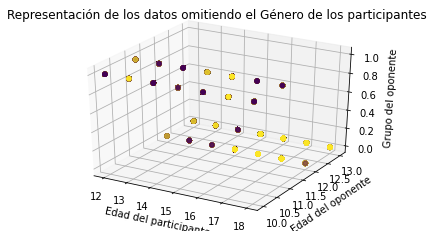

In [135]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x['Pa_Age'], x['Op_Age'], x['Group_Op_Civ_1_guer_0'], 
           c=x[['Op_Action_Push_1_Pull_0']])
ax.set_xlabel('Edad del participante')
ax.set_ylabel('Edad del oponente')
ax.set_zlabel('Grupo del oponente')
ax.set_title("Representación de los datos omitiendo el Género de los participantes")

plt.show()

Los puntos claros indican que el oponente cooperó con el participante, mientras que los mmás oscuros muestran lo contrario.
Es necesario anotar que no parece haber una separación trivial en los datos, ya que, aunque se encuentran en regiones definidas, tienen una alta dimensionalidad que para calidad de los análisis, y pese a que reducirla mejora el desempeño de muchos modelos, en este caso es irreductible. Se probará entonces con modelos lineales y no lineales dada esta escasa claridad.

Se crea un método que permitirá evaluar el desempeño de cada modelo creado, constará de la presentación de sus errores de entrenamiento y prueba y el área bajo su respectiva **Curva ROC** que mide cuán buena es la clasificación hecha por el modelo basándose en la proporción de verdaderos positivos y negativos.

In [136]:
def accuracy(model, x_train, y_train, x_test, y_test):
  y_pred_proba = model.predict_proba(x_test)[::,1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

  auc = metrics.roc_auc_score(y_test, y_pred_proba)

  print('Error en entrenamiento: {}'.format(1-model.score(x_train, y_train)))
  print('Error en prueba: {}'.format(1-model.score(x_test, y_test)))
  print("Area under roc curve:", auc)

  plt.plot(fpr,tpr,label="data 1, auc="+str(auc), linewidth = 6)
  plt.legend(loc=4)
  plt.show()

Es posible considerar las edades del participante y el oponente como categóritcas, por lo que se hará una transformación en el conjunto de datos, donde cada edad será representada por una columna.

In [137]:
cat_cols = ['Pa_Age', 'Op_Age']



In [138]:
def categorify(cat, x_train, x_test):
  preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )
  x_train_prep = preprocessor.fit_transform(x_train)
  x_test_prep  = preprocessor.transform(x_test)
  return (x_train_prep, x_test_prep)

In [139]:
x_train_prep, x_test_prep = categorify(cat_cols, x_train, x_test)

####Random Forest
Un modelo útil a la hora de enfrentar problemas de clasificación, su fortaleza está en prevenir el sobreajuste. Con el fin de obtener el mejor modelo posible, se utiliza **Validación cruzada** para determinar el número de árboles y la cantidad apropiada de características a usar.

In [140]:
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

In [141]:
rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=1, n_jobs=-1, cv=5)

In [142]:
rf = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

In [86]:
rf.fit(x_train_prep, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=123), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 10, 20],
                         'max_features': [5, 7, 9], 'n_estimators': [150]},
             return_train_score=True, scoring='accuracy')

Error en entrenamiento: 0.22613914954772174
Error en prueba: 0.2759811616954474
Area under roc curve: 0.6900192319918621


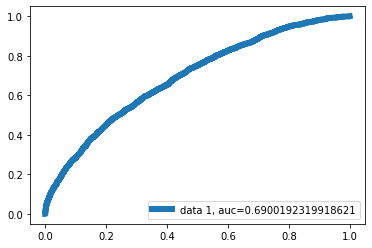

In [87]:
accuracy(rf, x_train_prep, y_train, x_test_prep, y_test)

Con el fin de mejorar el desempeño del modelo, se dejará de lado la columna del tiempo tomado por el oponente. ya que este fué generado aleatoriamente y funciona únicamente para simular que se juega contra un humano.

In [143]:
features = ['Id_Pa', 'Op_Time', 'Pa_Action_Push_1_Pull_0',
                'Pa_School', 'Date_Round', 'Date_Game']
pred = 'Pa_Action_Push_1_Pull_0'
x, y, x_train, x_test, y_train, y_test =  prepare(df, features, pred)

In [144]:
x_train_prep, x_test_prep = categorify(cat_cols, x_train, x_test)

In [145]:
rf.fit(x_train_prep, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=123), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 10, 20],
                         'max_features': [5, 7, 9], 'n_estimators': [150]},
             return_train_score=True, scoring='accuracy')

Error en entrenamiento: 0.22952066954095862
Error en prueba: 0.2751962323390895
Area under roc curve: 0.69339046470869


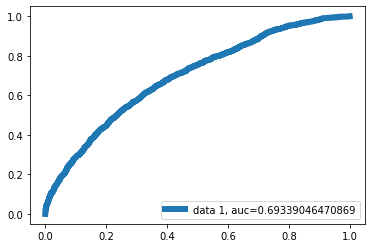

In [146]:
accuracy(rf, x_train_prep, y_train, x_test_prep, y_test)

Gracias a la aplicación de **One-hot encoding** sobre las columas de edad y la eliminación de características que dan ruido al modelo, se consiguió una precisión del 72.49%.
La curva ROC indica que los participantes no tuvieron en cuenta alguna entrategia en particular para desarrollar el juego, conclusión a la que se llega teniendo en cuenta que el área debajo de esta es más cercana a 0.5 que a 1.

###Valor de Shapley
Esto dará la facilidad para determinar la importancia de cada variable en la decisión tomada por un modelo, en este caso, se tendrá en cuenta en Random Forest al ser el que tiene mejor desempeño.

In [147]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 28.5 MB/s eta 0:00:00


In [148]:
import xgboost as xgb
import shap
import seaborn as sns 

Se debe transformar de nuevo el conjunto ```x_train_prep``` en un ```DataFrame``` cuyas columnas tengas título.

In [149]:
cols = x_train.drop(cat_cols, axis=1).columns
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([cols, encoded_cat])

x_train_prep = pd.DataFrame(x_train_prep, columns=labels)
x_test_prep  = pd.DataFrame(x_test_prep, columns=labels)


In [150]:
x_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11829 entries, 0 to 11828
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Game                     11829 non-null  float64
 1   Round                    11829 non-null  float64
 2   Op_Action_Push_1_Pull_0  11829 non-null  float64
 3   Group_Op_Civ_1_guer_0    11829 non-null  float64
 4   Pa_Gender_F_1_M_0        11829 non-null  float64
 5   Op_Name_Naugh_0_Nice_1   11829 non-null  float64
 6   Op_Gender_F_!_M_0        11829 non-null  float64
 7   Pa_Age_12                11829 non-null  float64
 8   Pa_Age_13                11829 non-null  float64
 9   Pa_Age_14                11829 non-null  float64
 10  Pa_Age_15                11829 non-null  float64
 11  Pa_Age_16                11829 non-null  float64
 12  Pa_Age_17                11829 non-null  float64
 13  Pa_Age_18                11829 non-null  float64
 14  Op_Age_10             

Se extraen los parámetros obtenidos en la validación cruzada para crear un modelo concreto de Random Forest, luego se entrena con los datos destinados para tal fin.

In [151]:
rf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150}

In [158]:
rf = RandomForestClassifier(n_estimators=150, max_features=5, max_depth=10, criterion='gini')
rf.fit(x_train_prep, y_train)

RandomForestClassifier(max_depth=10, max_features=5, n_estimators=150)

Se utiliza un ```TreeExplainer``` ya que es el que mejor se ajusta a este tipo de modelo.

In [160]:
explainer = shap.TreeExplainer(rf, data= x_train_prep)

In [161]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [162]:
sv = explainer.shap_values(x_train_prep)

100%|===================| 23654/23658 [15:14<00:00]       

In [164]:
sV = explainer(x_train_prep)

100%|===================| 23656/23658 [15:20<00:00]       

In [165]:
print_feature_importances_shap_values(sV, x_test.columns)

Round -> 0.0275 (softmax = 0.0563)
Pa_Age -> 0.0191 (softmax = 0.0558)
Group_Op_Civ_1_guer_0 -> 0.0123 (softmax = 0.0554)
Pa_Gender_F_1_M_0 -> 0.0067 (softmax = 0.0551)
Game -> 0.0059 (softmax = 0.0551)
Op_Age -> 0.0049 (softmax = 0.0550)
Op_Action_Push_1_Pull_0 -> 0.0047 (softmax = 0.0550)
Op_Gender_F_!_M_0 -> 0.0039 (softmax = 0.0550)
Op_Name_Naugh_0_Nice_1 -> 0.0033 (softmax = 0.0549)


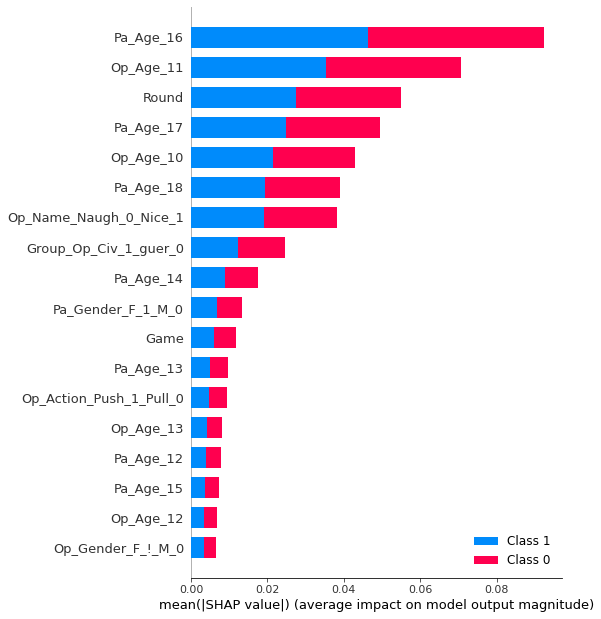

In [167]:
shap.summary_plot(sv, x_train_prep)

Para ambas clases, las variables tienen influencias similares, dadas las frecuencias de los datos, se evidencia que esta es mayor al no cooperar (barras rojas).

 Estos resultados concuerdan con los observados en el análisis previo, donde se observaba una relación importante entre el número de ronda y la cooperación del participante, pues, se muestra como la variable con mayor importancia a la hora de tomar una decisión. En orden de importancia, las variables se tienen en cuenta del siguiente modo:

- Ronda
- Edades de los participantes 
- Grupo al que pertenece el oponente
- Género del participante
- Juego
- Edad del oponente
- Acción del oponente
- Género del oponente
- Op_Name_naugh

Es interesante anotar que las acciones del oponente no insiden de forma significativa en la cooperación del participante, pero que al mismo tiempo, la edad y el género de este sean más importantes de lo que parecen. El rol del oponente juega un papel importante, pero contrario a la hipótesis, no es lo fundamental.

##Consideraciones Finales

Ahora que se comprende de una mejor manera la influencia de cada variable en la decisión de cooperación de un participante, se pueden ver con claridad ciertas relaciones

###Relación entre género y cooperación 
A continuación, se muestra la relación del género de los participantes con la cooperación

In [168]:
coop_count = df['Pa_Action_Push_1_Pull_0'].value_counts()
print("Total Defection " + str(coop_count[0]))
print("Total Cooperation " + str(coop_count[1]))

crosstab = pd.crosstab(df["Pa_Gender_F_1_M_0"], df["Pa_Action_Push_1_Pull_0"])
crosstab #Cooperate more with Guerrillas, Defect More with Civilians?


Total Defection 12840
Total Cooperation 5359


Pa_Action_Push_1_Pull_0,0,1
Pa_Gender_F_1_M_0,,
0,7445,2554
1,5395,2805


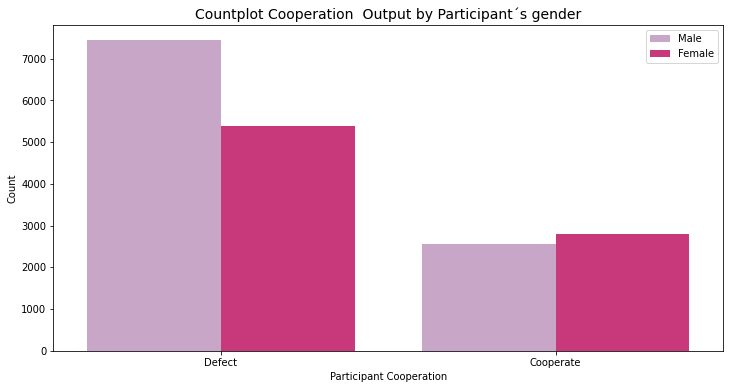

In [179]:

g, (ax2) = plt.subplots(1,1, sharex=True, figsize=(12,6))

ax2.set_title('Countplot Cooperation  Output by Participant´s gender', fontsize=14)

#Subplot 2 - 
sns.countplot(ax=ax2, x='Pa_Action_Push_1_Pull_0', hue= 'Pa_Gender_F_1_M_0',
              data = df, palette = 'PuRd') 
plt.xlabel('Participant Cooperation', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks([0, 1], ['Defect', 'Cooperate'], fontsize=10)
plt.legend(["Male", "Female"])

En general, ambos géneros tienden a no cooperar, sin embargo, los hombres se muestran menos cooperativos que las mujeres.

###Relación entre edad y cooperación
A continuación se muestra como varía la cooperación respecto a la edad de los participantes.

In [169]:
coop_count = df['Pa_Action_Push_1_Pull_0'].value_counts()
print("Total Defection " + str(coop_count[0]))
print("Total Cooperation " + str(coop_count[1]))

#How cooperative are civilians with Guerrilla? 
crosstab = pd.crosstab(df["Pa_Age"], df["Pa_Action_Push_1_Pull_0"])
crosstab

Total Defection 12840
Total Cooperation 5359


Pa_Action_Push_1_Pull_0,0,1
Pa_Age,,
12,854,246
13,3232,868
14,2537,962
15,2712,1288
16,2558,1242
17,574,526
18,373,227


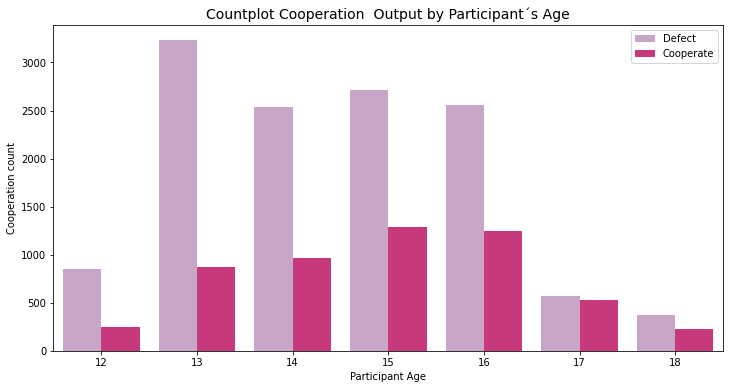

In [183]:

g, (ax2) = plt.subplots(1,1, sharex=True, figsize=(12,6))

ax2.set_title('Countplot Cooperation  Output by Participant´s Age', fontsize=14)

#Subplot 2 - 
sns.countplot(ax=ax2, x='Pa_Age', hue= 'Pa_Action_Push_1_Pull_0',
              data = df, palette = 'PuRd') 
plt.xlabel('Participant Age', fontsize=10)
plt.ylabel('Cooperation count', fontsize=10)
plt.legend(["Defect", "Cooperate"])

A los 12, 17 y 18 años hay una cooperación más balanceada respecto a la no cooperación, por otro lado, en el resto de las edades la no cooperación es mucho mayor.

###Comparación del modelo con la realidad
Se hará una comparativa de las estadísticas de cooperación ofrecidas por el modelo de *Random Forest* con los datos capturados origianlmente

In [188]:
y_preds = rf.predict(x_test_prep)
type(y_preds)


numpy.ndarray

([<matplotlib.axis.XTick at 0x7fb45531b430>,
 [Text(0, 0, 'Defect'), Text(0, 0, 'Cooperate')])

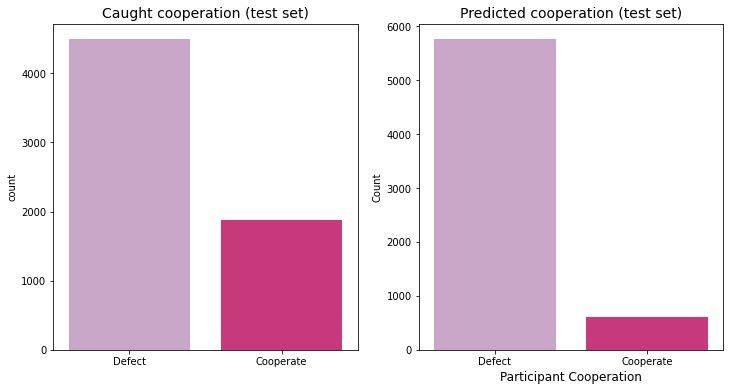

In [189]:

g, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,6))

ax1.set_title('Caught cooperation (test set)', fontsize=14)
ax2.set_title('Predicted cooperation (test set)', fontsize=14)

sns.countplot(ax=ax1, x=y_test.values, palette = 'PuRd') 
plt.xlabel('Participant Cooperation', fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.xticks([0, 1], ['Defect', 'Cooperate'], fontsize=10)

sns.countplot(ax=ax2, x=y_preds, palette = 'PuRd') 
plt.xlabel('Participant Cooperation', fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.xticks([0, 1], ['Defect', 'Cooperate'], fontsize=10)


In [191]:
print(pd.DataFrame(y_test).value_counts())
print(pd.DataFrame(y_preds).value_counts())

Pa_Action_Push_1_Pull_0
0                          4494
1                          1876
dtype: int64
0    5759
1     611
dtype: int64


El modelo es más pesimista sobre la cooperación, prediciendo que es una pequeña parte de los participantes la que tomará la decisión de cooperar.

|Fuente|No Cooperación | Cooperación |
|------|---------------|-------------|
|Datos |4494           |1876         |
|Modelo|5759           |611          |